In [2]:
from openmm.unit import kelvin, picosecond, femtosecond, nanometer, dalton
import openmm as mm

import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import numpy as np

from energy_landscape import landscape
from muller_utils import random_init_point, target_init_point
import os, pickle, yaml
from datetime import datetime

# Parameter Set-up

In [3]:
# random start or target start
# random start: set the intial position randomly
# target start: set the initial position to the target position (the lowest energy point)
start_mode = 'target'

# Get the current time
current_time = datetime.now()
formatted_time = current_time.strftime('%y%m%d_%H%M')
directory = f"results/mod_muller/LD/{start_mode}_{formatted_time}"
if not os.path.exists(directory):
    os.makedirs(directory)
print(directory)

results/mod_muller/LD/target_240508_1548


In [4]:
# Observation Guided Navigation parameters
random_seed = 1
np.random.seed(random_seed)
total_step = 10000       # total number of steps

# Brownian simulation parameters
## each particle is totally independent, propagating under the same potential
nParticles = 1  
temp_non_dimensional = 750
mass_non_dimensional = 1.0
friction_non_dimensional = 100
timestep_non_dimensional = 10.0
step = 100
temperature = temp_non_dimensional * kelvin
mass = mass_non_dimensional * dalton
friction = friction_non_dimensional / picosecond
timestep = timestep_non_dimensional * femtosecond


# set up x and y limits for the plot
x_limits = (-3.5, 2.0)
y_limits = (-1.2, 3.5)

# define initial point
if start_mode == 'random':
    init = random_init_point(x_limits, y_limits) # np.array([-0.9, 1.4, np.random.uniform(0, 1)])
elif start_mode == 'target':
    init = target_init_point(-0.85, 1.3)

label_1 = 'LD'

In [5]:
# save the setting as a yaml file
# Define all other parameters and include them in a dictionary
parameters = {
    'start_mode': start_mode,
    'total_step': total_step,
    'random_seed': random_seed,
    'nParticles': nParticles,
    'mass': mass_non_dimensional,
    'temperature': temp_non_dimensional,
    'friction': friction_non_dimensional,
    'timestep': timestep_non_dimensional,
    'step': step,
}

# Serialize and save as a YAML file
with open(os.path.join(directory, 'param.yaml'), 'w') as file:
    yaml.dump(parameters, file)

# Run simulation

In [6]:
# LD simulation set-up
system = mm.System()
pes = landscape('Modified_Muller')

for i in range(nParticles):
    system.addParticle(mass)
    pes.addParticle(i, [])
system.addForce(pes)

integrator = mm.LangevinIntegrator(temperature, friction, timestep)
context = mm.Context(system, integrator)

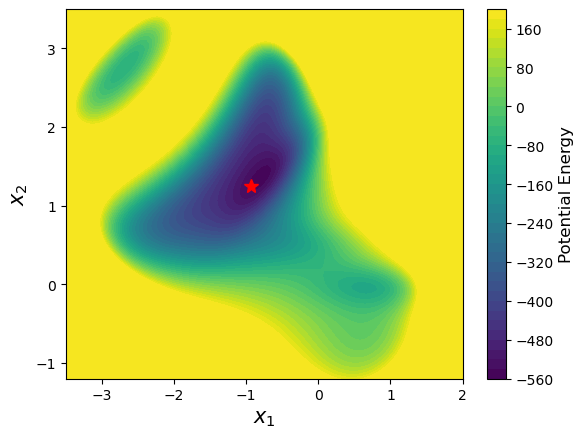

In [7]:
# check initial point location
ft = 15
e = 0.2
pes.plot(ax=plt.gca(), 
         minx=x_limits[0]-e, maxx=x_limits[1]+e, 
         miny=y_limits[0]-e, maxy=y_limits[1]+e)

plt.plot(init[:, 0], init[:, 1], '*', color='r', markersize=10)
plt.xlabel('$x_1$', fontsize=ft)
plt.ylabel('$x_2$', fontsize=ft)
plt.xlim(x_limits[0], x_limits[1])
plt.ylim(y_limits[0], y_limits[1])
plt.show()

step 0: | cent: [  -0.93    1.26 -546.36]
step 1000: | cent: [  -0.81    1.35 -547.24]
step 2000: | cent: [  -0.82    1.35 -547.1 ]
step 3000: | cent: [  -0.81    1.35 -547.48]
step 4000: | cent: [  -0.81    1.35 -547.45]
step 5000: | cent: [  -0.82    1.35 -547.43]
step 6000: | cent: [  -0.81    1.35 -547.23]
step 7000: | cent: [  -0.81    1.35 -547.77]
step 8000: | cent: [  -0.82    1.35 -547.64]
step 9000: | cent: [  -0.81    1.35 -547.57]


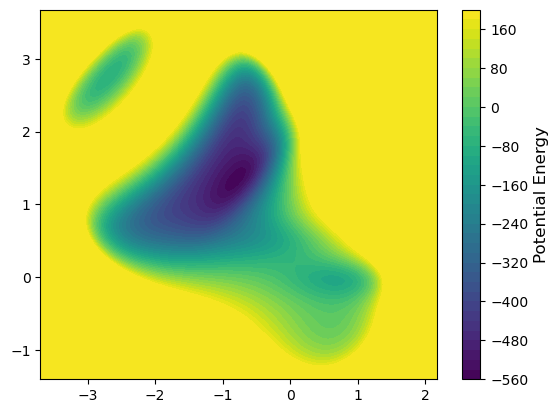

In [8]:
# run Langevin dynamics
startingPositions = init
interval = 1000
pes.plot(ax=plt.gca(), 
         minx=x_limits[0]-e, maxx=x_limits[1]+e, 
         miny=y_limits[0]-e, maxy=y_limits[1]+e)


context.setPositions(startingPositions)
context.setVelocitiesToTemperature(temperature)

traj = np.zeros((total_step, 3))
for i in range(total_step):
    # Assuming context, pes, and integrator are predefined and properly set up
    x = context.getState(getPositions=True).getPositions(asNumpy=True).value_in_unit(nanometer)   
    p = x[0]
    E = pes.potential(x=p[0], y=p[1])  # Ensure pes.potential() handles inputs safely and returns a sensible value
    
    traj[i] = np.array([p[0], p[1], E])
    integrator.step(step)

    # Ensure we have a valid range for calculating the mean
    if i > 0:  # Ensure there's at least one step to average
        start_index = max(0, i-interval)
        # Use np.nanmean to safely calculate the mean, ignoring NaN values
        cent = np.nanmean(traj[start_index:i], axis=0)
        if (i % interval == 0): 
            print(f'step {i}: | cent: {np.round(cent.flatten(),2)}')
    else:
        # For the very first step, just print the current position
        print(f'step {i}: | cent: {np.round(traj[i].flatten(),2)}')

In [9]:
# save the Langevin dynamics trajectory
result = {
    'init': init,
    'traj_all_save': traj
}

# save the result into pickle
with open(os.path.join(directory, 'result.pkl'), 'wb') as file:
    pickle.dump(result, file)

# Import results and run analysis

In [10]:
# read the tarjectory
# to read other results, change the directory like example:
# directory = 'results/mod_muller/LD/target_240216_2112'

with open(os.path.join(directory, 'result.pkl'), 'rb') as file: 
    result = pickle.load(file)

init = result['init']
traj = result['traj_all_save']

In [11]:
# figure setting
# set up x and y limits for the plot
x_limits = (-3.5, 2.0)
y_limits = (-1.2, 3.5)
ft = 18
e = 0.2
label_1 = 'LD'

pes = landscape('Modified_Muller')

# All data points

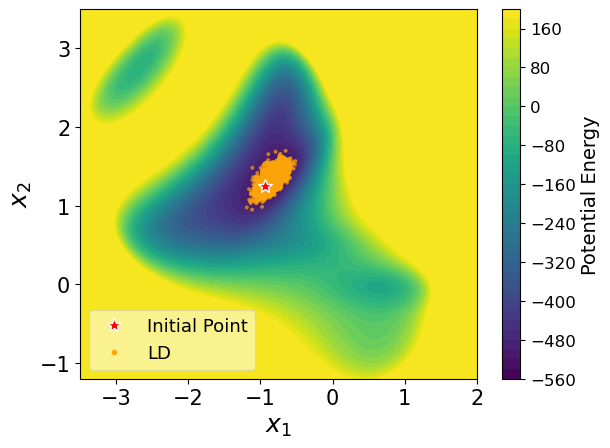

In [12]:
pes.plot(ax=plt.gca(), 
         minx=x_limits[0]-e, maxx=x_limits[1]+e, 
         miny=y_limits[0]-e, maxy=y_limits[1]+e,
         fontsize=ft-4)

colors = cm.inferno(np.linspace(0.8, 0.2))
plt.plot(init[:, 0], init[:, 1], 
         '*', markeredgecolor='white', color='r', 
         markersize=10, label='Initial Point')

plt.scatter(traj[:,0], traj[:,1], 
            edgecolor='none', 
            s=8, color=colors[0], 
            alpha=0.7) #, label=f'Data Point')

plt.xlabel('$x_1$', fontsize=ft)
plt.ylabel('$x_2$', fontsize=ft)
plt.xlim(x_limits[0], x_limits[1])
plt.ylim(y_limits[0], y_limits[1])
plt.xticks(fontsize=ft-3)
plt.yticks(fontsize=ft-3)
plt.plot([], [], '.', c='orange', label=label_1) 

plt.legend(fontsize=ft-5, loc='lower left', framealpha=0.5)
plt.savefig(os.path.join(directory,'all_points.png'), bbox_inches='tight', facecolor='w')
plt.show()

# SSIR

In [13]:
interval = 0.8
command = f"python ssir_modified_muller_LD.py --dir {directory.split('/')[-1]} --interval {interval} --num_step {total_step}"
!{command}

  0%|                                                     | 0/4 [00:00<?, ?it/s]/home/hoon/boltzmann/OGN/energy_landscape.py:138: RuntimeWarning: overflow encountered in exp
  value += self.AA[j] * np.exp(self.aa[j] * (x - self.XX[j])**2 + \
100%|█████████████████████████████████████████████| 4/4 [01:03<00:00, 15.91s/it]
